#### Group Members: Michael Woo, Thomas Slawinski, Akaash Patel, Rahul Patel

##### Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import imageio
from PIL import Image
import ipyplot
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
import pathlib
import io
import os
import requests
import pathlib
import gzip
import imageio
import pandas as pd

##### Exploring the data

In [3]:
import pathlib
data_dir = "hpa-single-cell-image-classification/train"
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = os.listdir(data_dir)
len(image_count)

87224

In [5]:
df_train = pd.read_csv("hpa-single-cell-image-classification/train.csv")
df_train.head()

ID  Label
0  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0  8|5|0
1  5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0   14|0
2  60b57878-bb99-11e8-b2b9-ac1f6b6435d0    6|1
3  5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0  16|10
4  5b931256-bb99-11e8-b2b9-ac1f6b6435d0   14|0

In [6]:
df_samp_sub = pd.read_csv("hpa-single-cell-image-classification/sample_submission.csv")
df_samp_sub.head()

ID  ImageWidth  ImageHeight  \
0  0040581b-f1f2-4fbe-b043-b6bfea5404bb        2048         2048   
1  004a270d-34a2-4d60-bbe4-365fca868193        2048         2048   
2  00537262-883c-4b37-a3a1-a4931b6faea5        2048         2048   
3  00c9a1c9-2f06-476f-8b0d-6d01032874a2        2048         2048   
4  0173029a-161d-40ef-af28-2342915b22fb        3072         3072   

           PredictionString  
0  0 1 eNoLCAgIMAEABJkBdQ==  
1  0 1 eNoLCAgIMAEABJkBdQ==  
2  0 1 eNoLCAgIMAEABJkBdQ==  
3  0 1 eNoLCAgIMAEABJkBdQ==  
4  0 1 eNoLCAgIsAQABJ4Beg==

In [7]:
train_images = "hpa-single-cell-image-classification/train"
train_images = os.listdir(train_images)
#train_images

### Note
*  the following code below shows that there are 4 images in the train folder assoicated with the image ID that corresponds to Red, Blue, Green, and Yellow channels...In other words, 4 images per ID that are differentiated by color (Red, Blue, Green, Yellow)

In [8]:
len(df_train), len(train_images), len(train_images)/len(df_train)

(21806, 87224, 4.0)

##### Number of labels per images
* We can see that there are more than 10,000 images that are composed of 1 label out of the 18 labels so due to space constraints we will stick with the 1 label images

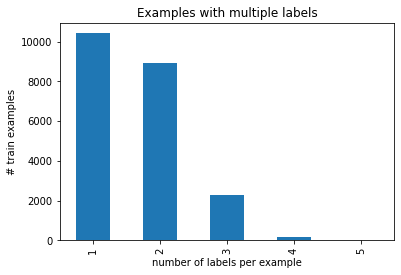

In [9]:
df_train['num_classes'] = df_train['Label'].apply(lambda r: len(r.split('|')))
df_train['num_classes'].value_counts().plot.bar(title='Examples with multiple labels', xlabel='number of labels per example', ylabel='# train examples')
plt.show()

##### Things to keep in mind regarding channels
* Red (Microtubules)
* Green (Protein of interest)
* Blue (Nucleus)
* Yellow (Endoplasmic reticulum)

##### Here we seperate the images based on the ID and color

In [10]:
path = "hpa-single-cell-image-classification"
mt = [path+'/train/'+(id+'_red.png') for id in df_train.ID.values]
er = [path+'/train/'+(id+'_yellow.png') for id in df_train.ID.values]
nu = [path+'/train/'+(id+'_blue.png') for id in df_train.ID.values]
pr = [path+'/train/'+(id+'_green.png') for id in df_train.ID.values]
images = [mt, er, nu, pr]
titles = ['microtubules', 'endoplasmic reticulum', 'nucleus', 'protein of interest']

##### Viewing the images 
* Images by themselves (no stack)

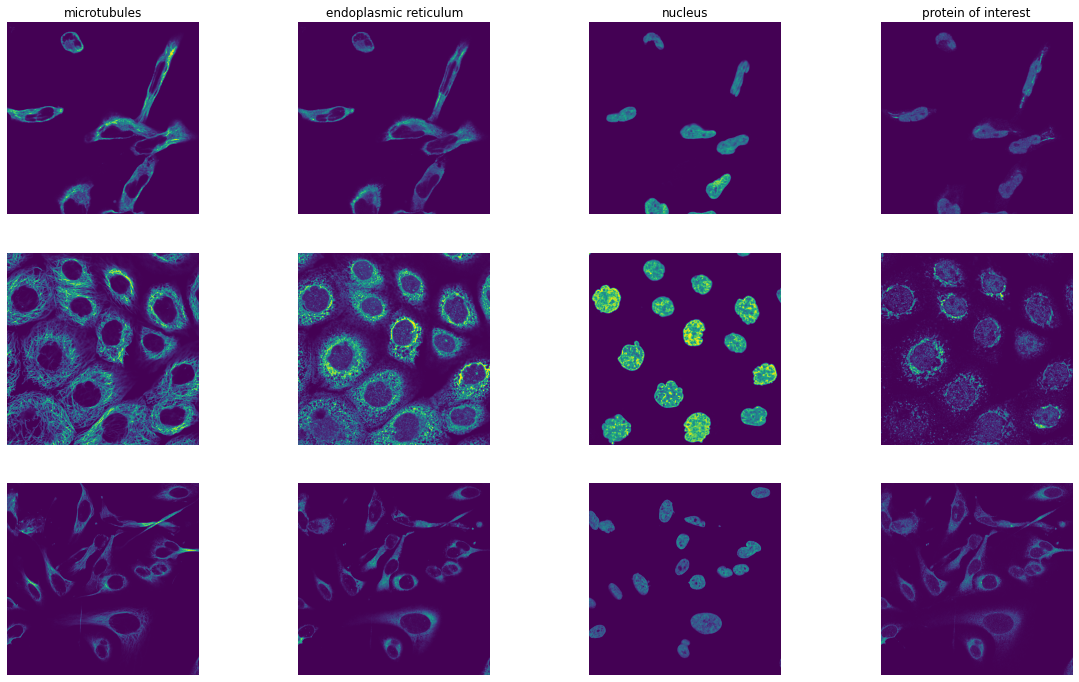

In [11]:
fig, ax = plt.subplots(3,4, figsize=(20,12))
for j in range(3):
    for i in range(4):
        img = plt.imread(images[i][j])
        if j == 0: ax[j,i].set_title(titles[i])
        ax[j,i].imshow(img)
        ax[j,i].axis('off')
plt.show()

##### Generating Stacked Images (Feature Engineering)
* These are images stacked (red, yellow, blue)


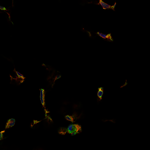
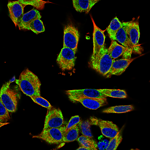
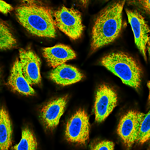
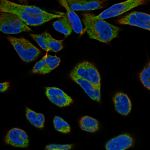
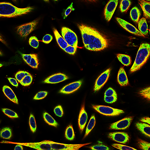
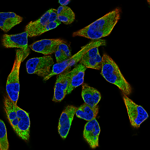
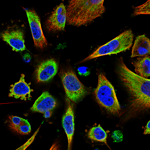
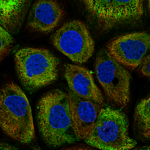
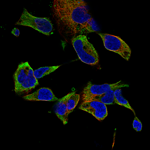
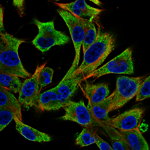
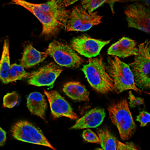
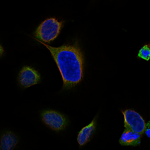
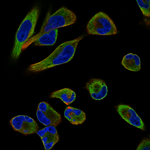
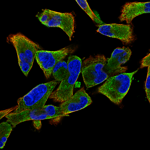
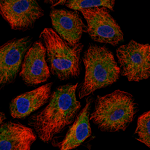
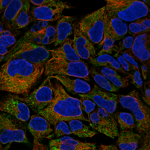
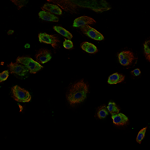
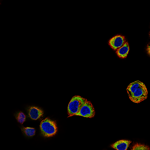
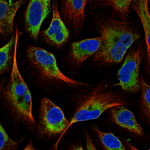


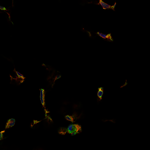
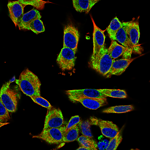
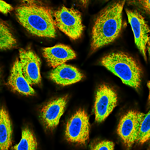
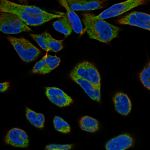
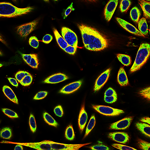
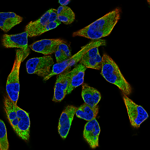
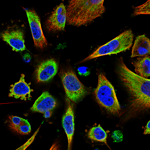
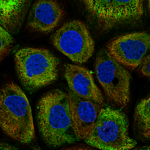
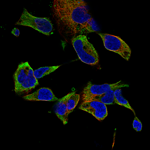
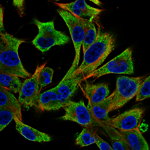
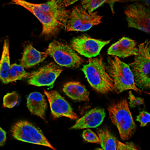
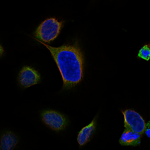
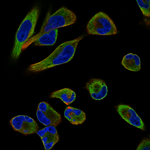
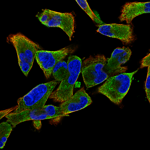
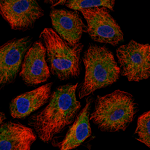
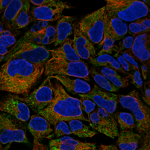
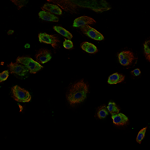
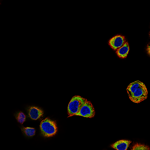
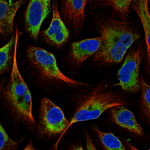

In [12]:
labels = [str(i) for i in range(19)]
class_images = []
for label in labels:
    r_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[0] + '_red.png'
    y_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[0] + '_yellow.png'
    b_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[0] + '_blue.png'
    r = imageio.imread(path+'/train/'+r_img)
    y = imageio.imread(path+'/train/'+y_img)
    b = imageio.imread(path+'/train/'+b_img)
    rgb = np.dstack((r,y,b))
    #print(r.shape)
    class_images.append(PIL.Image.frombytes('RGB',r.shape,rgb))

codes = [
'0. Nucleoplasm',
'1. Nuclear membrane',
'2. Nucleoli',
'3. Nucleoli fibrillar center',
'4. Nuclear speckles',
'5. Nuclear bodies',
'6. Endoplasmic reticulum',
'7. Golgi apparatus',
'8. Intermediate filaments',
'9. Actin filaments',
'10. Microtubules',
'11. Mitotic spindle',
'12. Centrosome',
'13. Plasma membrane',
'14. Mitochondria',
'15. Aggresome',
'16. Cytosol',
'17. Vesicles and punctate cytosolic patterns',
'18. Negative'
]

#ipyplot.plot_images(images=class_images, labels=codes, max_images=19, img_width=300)
ipyplot.plot_images(images=class_images, labels=codes, max_images=19)

##### Generating directories and saving images with respect to the labels associated to the images
* Only run this once

In [13]:
# # per label 
# labels = [str(i) for i in range(19)]
# code = [
# '00_Nucleoplasm',
# '01_Nuclear_membrane',
# '02_Nucleoli',
# '03_Nucleoli_fibrillar_center',
# '04_Nuclear_speckles',
# '05_Nuclear_bodies',
# '06_Endoplasmic_reticulum',
# '07_Golgi_apparatus',
# '08_Intermediate_filaments',
# '09_Actin_filaments',
# '10_Microtubules',
# '11_Mitotic_spindle',
# '12_Centrosome',
# '13_Plasma_membrane',
# '14_Mitochondria',
# '15_Aggresome',
# '16_Cytosol',
# '17_Vesicles_and_punctate_cytosolic_patterns',
# '18_Negative'
# ]

# for label in labels:
#     img_counter = len(df_train[df_train.Label == label])
#     print("Generating Images for "+code[int(label)] )
#     for i in range(img_counter):
#         try:
#             r_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[i] + '_red.png'
#             y_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[i] + '_yellow.png'
#             b_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[i] + '_blue.png'
#             name = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[i]

#             r = imageio.imread(path+'/train/'+r_img)
#             y = imageio.imread(path+'/train/'+y_img)
#             b = imageio.imread(path+'/train/'+b_img)
#             rgb = np.dstack((r,y,b))
            
#             image_name = PIL.Image.frombytes('RGB',r.shape,rgb)
#             resized_image = image_name.resize((180,180))

#             if not os.path.exists("data/"+code[int(label)]):
#                 os.makedirs("data/"+code[int(label)])

#             resized_image.save("data/"+code[int(label)]+"/"+ name + ".png")
#         except:
#             print("Unable to save image with this label: "+ code[int(label)])
    
#     print("Completed Generating Images for "+code[int(label)])

##### Further Feature Engineering
* Stacking the images so that they are able to express the protein of interest along with their landmarks
* StandardScaler the pixel values from 0-255 range to 0-1 range, ImageDataGenerator class can be used. The range in 0-1 scaling is known as Normalization.

##### Size of images and batch size variables

In [14]:
batch_size = 32
img_height = 180
img_width = 180

##### Training Data Generator

In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
 "./data",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10412 files belonging to 19 classes.
Using 8330 files for training.


##### Validation Data Generator

In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "./data",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10412 files belonging to 19 classes.
Using 2082 files for validation.


##### Training Data

In [17]:
x_train = list()
y_train = list()
for raw_data,labels in train_ds:
    y_train.extend(np.array(labels))
   # print(labels)
    for image_data_per in raw_data:
        x_train.append(np.array(image_data_per))
x_train = np.array(x_train).reshape(-1,(180*180*3))
print(x_train.shape)
y_train = np.array(y_train)
print(y_train.shape)

(8330, 97200)
(8330,)


##### Validation data

In [18]:
x_test = list()
y_test = list()
for raw_data,labels in val_ds:
    y_test.extend(np.array(labels))
    #print(labels)
    for image_data_per in raw_data:
        x_test.append(np.array(image_data_per))
x_test = np.array(x_test).reshape(-1,(180*180*3))
print(x_test.shape)
y_test = np.array(y_test)
print(y_test.shape)

##### Subsetting Data
- Using less images to more quickly compute models
- Only using 1000 images for training
- Only using 100 images for testing

In [25]:
x_train = x_train[0:1000]
y_train = y_train[0:1000]
x_test = x_test[0:100]
y_test = y_test[0:100]

##### Create functions to create multi-label AUC_ROC curve

In [55]:
import sklearn.metrics as metrics
import seaborn as sns
"""
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    label_ = dict(code)
    
    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (AUC = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
"""

'\ndef plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):\n    y_score = clf.decision_function(X_test)\n\n    # structures\n    fpr = dict()\n    tpr = dict()\n    roc_auc = dict()\n    label_ = dict(code)\n    \n    # calculate dummies once\n    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values\n    for i in range(n_classes):\n        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])\n        roc_auc[i] = metrics.auc(fpr[i], tpr[i])\n\n    # roc for each class\n    fig, ax = plt.subplots(figsize=figsize)\n    ax.plot([0, 1], [0, 1], \'k--\')\n    ax.set_xlim([0.0, 1.0])\n    ax.set_ylim([0.0, 1.05])\n    ax.set_xlabel(\'False Positive Rate\')\n    ax.set_ylabel(\'True Positive Rate\')\n    ax.set_title(\'Receiver operating characteristic example\')\n    for i in range(n_classes):\n        ax.plot(fpr[i], tpr[i], label=\'ROC curve (AUC = %0.2f) for label %i\' % (roc_auc[i], i))\n    ax.legend(loc="best")\n    ax.grid(alpha=.4)\

In [27]:
def plot_multiclass_roc_advanced(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (AUC = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

##### Naive Bayes Classifer

In [28]:
pipe = make_pipeline(StandardScaler(), GaussianNB())
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
print(classification_report(y_test,y_pred))
precision = precision_score(y_test, y_pred,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred,average='weighted')
print('Recall: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_test, y_pred,average='weighted')
print('F1 score: %f' % f1)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4
           4       0.08      0.40      0.14         5
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         2
           8       0.08      0.14      0.11         7
           9       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00        15
          15       0.00      0.00      0.00         2
          16       0.10      0.43      0.16         7
          17       0.00      0.00      0.00         5

    accuracy                           0.06       100
   macro avg       0.02   

c:\users\tom\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\tom\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\tom\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

##### Plot classification report results (Naive Bayes)

c:\users\tom\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\tom\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\tom\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Text(0.5, 1.0, 'Classification Report Plot')

<Figure size 432x288 with 0 Axes>

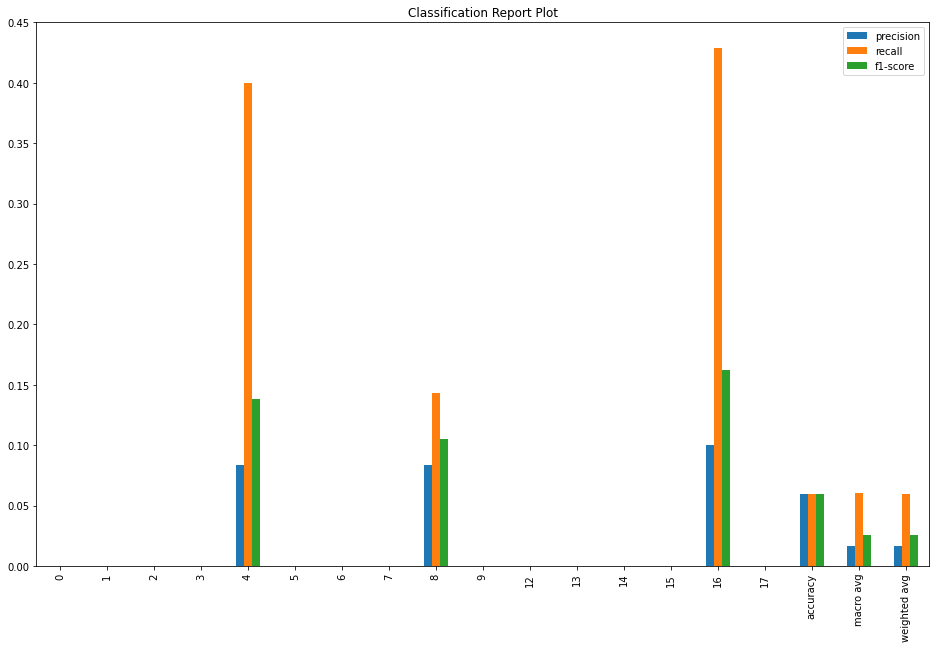

In [29]:
df = pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)).transpose()
plt.figure()
df[['precision','recall','f1-score']].iloc[0:19].plot(kind='bar',figsize=(16,10))
plt.legend(loc='best')
plt.title("Classification Report Plot")

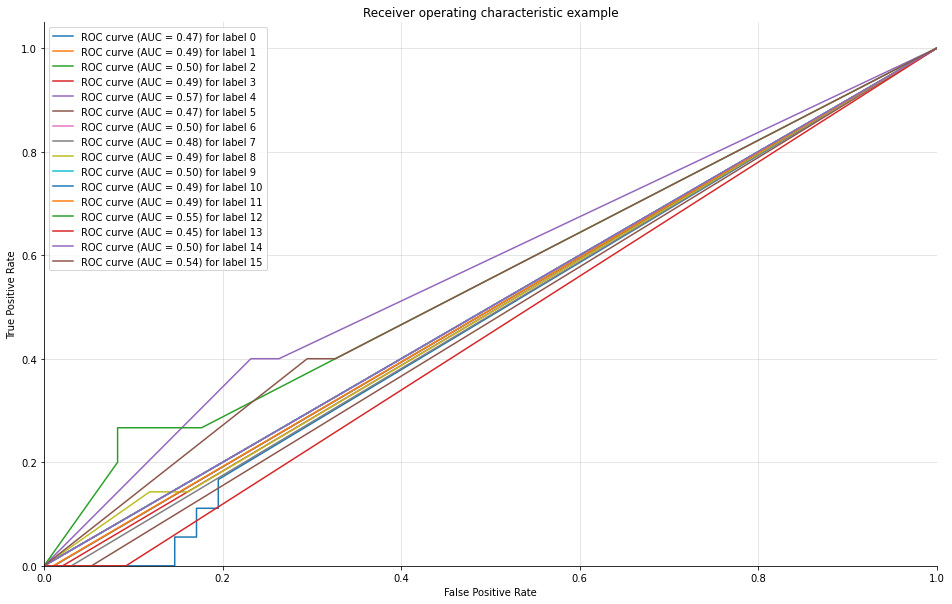

In [31]:
plot_multiclass_roc_advanced(pipe, x_test, y_test, n_classes=16, figsize=(16, 10))

##### Random Forest Classifer

In [32]:
pipe = make_pipeline(StandardScaler(), RandomForestClassifier())
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
print(classification_report(y_test,y_pred))
precision = precision_score(y_test, y_pred,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred,average='weighted')
print('Recall: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_test, y_pred,average='weighted')
print('F1 score: %f' % f1)


              precision    recall  f1-score   support

           0       0.31      0.78      0.44        18
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         5
           5       1.00      0.17      0.29         6
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         0
          12       0.00      0.00      0.00        11
          13       0.25      0.33      0.29         6
          14       0.26      0.33      0.29        15
          15       0.00      0.00      0.00         2
          16       0.08      0.14      0.11         7
          17       0.00      0.00      0.00         5

    accuracy              

c:\users\tom\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\tom\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\tom\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

##### Plot classification report results (Random Forest)

c:\users\tom\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\tom\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\tom\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

<Figure size 432x288 with 0 Axes>

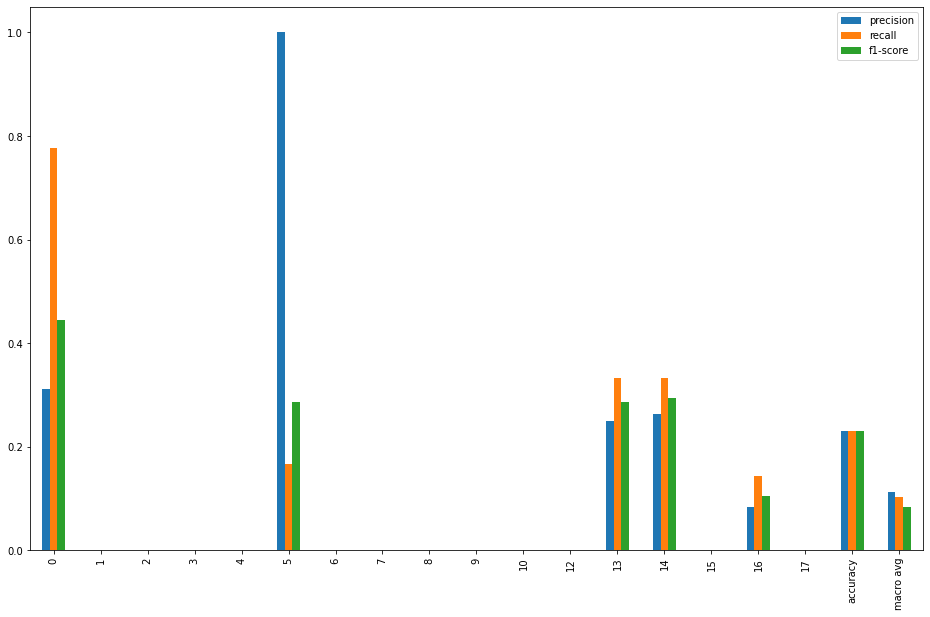

In [33]:
df = pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)).transpose()
plt.figure()
df[['precision','recall','f1-score']].iloc[0:19].plot(kind='bar',figsize=(16,10))
plt.legend(loc='best')

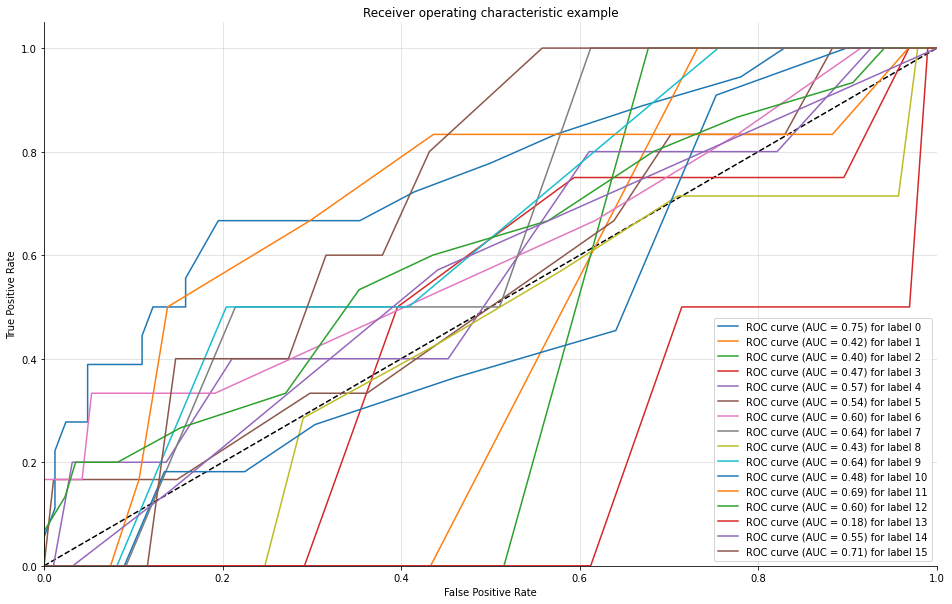

In [35]:
plot_multiclass_roc_advanced(pipe, x_test, y_test, n_classes=16, figsize=(16, 10))

#### XGBoost Classifer

##### Reducing subset specifically for XGBoost to speed up model training

In [37]:
x_train = x_train[0:100]
y_train = y_train[0:100]
x_test = x_test[0:10]
y_test = y_test[0:10]

In [38]:
pipe = make_pipeline(StandardScaler(), XGBClassifier())
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
print(classification_report(y_test,y_pred))
precision = precision_score(y_test, y_pred,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred,average='weighted')
print('Recall: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_test, y_pred,average='weighted')
print('F1 score: %f' % f1)

c:\users\tom\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         0
           4       1.00      0.50      0.67         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0

c:\users\tom\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\tom\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\tom\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

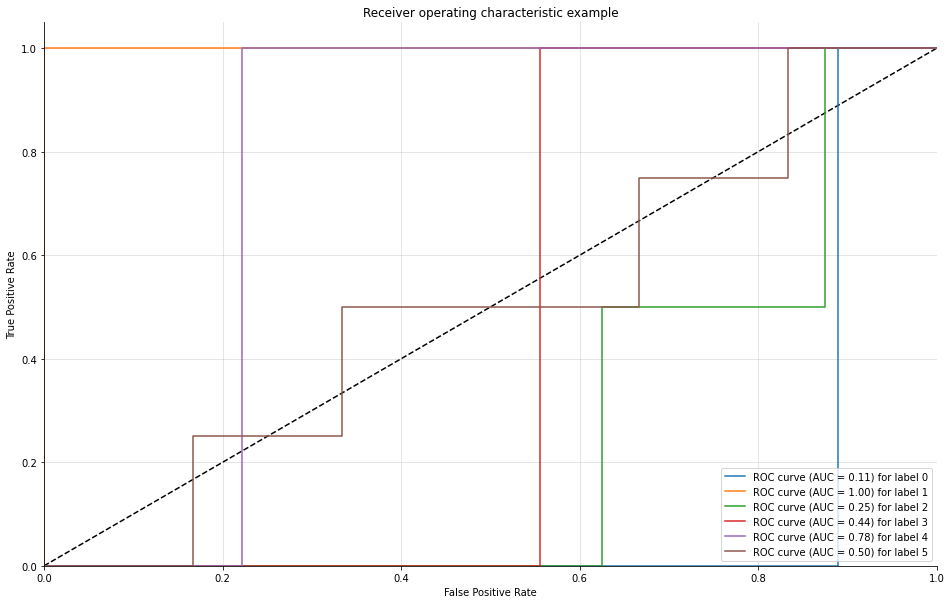

In [40]:
plot_multiclass_roc_advanced(pipe, x_test, y_test, n_classes=6, figsize=(16, 10))

##### Plot classification report results (XGBoost)

c:\users\tom\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\tom\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\tom\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

Text(0.5, 1.0, 'Classification Report Plot')

<Figure size 432x288 with 0 Axes>

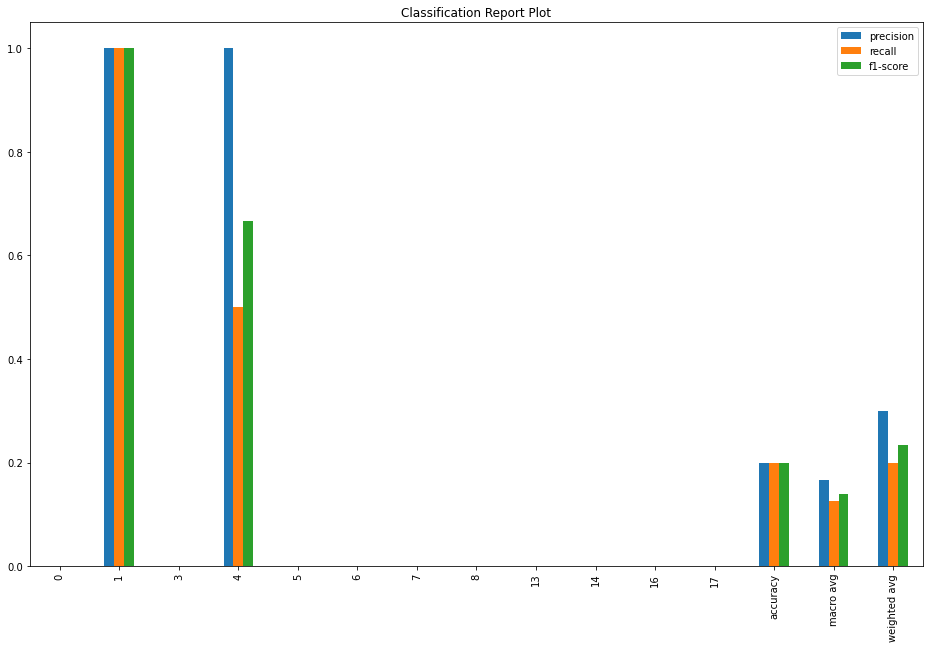

In [41]:
df = pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)).transpose()
plt.figure()
df[['precision','recall','f1-score']].iloc[0:19].plot(kind='bar',figsize=(16,10))
plt.legend(loc='best')
plt.title("Classification Report Plot")

## Cellular Masking (further potential feature engineering)
#### Idea: Mask images by color to generate more easily readble images to provide to the models as input 
#### Didn't perform due to limited computational resources and time when attempting to use a realistic sample size (3 stacked images per classification took almost an hour)

##### Function to convert .tif.gz to .png and put it in the same folder
* for working in local work station

In [42]:
def tif_gzip_to_png(tif_path):
    png_path = pathlib.Path(tif_path.replace('.tif.gz','.png'))
    tf = gzip.open(tif_path).read()
    img = imageio.imread(tf, 'tiff')
    imageio.imwrite(png_path, img)

##### Function to convert .tif.gz to .png and put it in the same folder

In [43]:
def download_and_convert_tifgzip_to_png(url, target_path):    
    r = requests.get(url)
    f = io.BytesIO(r.content)
    tf = gzip.open(f).read()
    img = imageio.imread(tf, 'tiff')
    imageio.imwrite(target_path, img)

##### All label names in the public HPA and their corresponding index

In [44]:
all_locations = dict({
    "Nucleoplasm": 0,
    "Nuclear membrane": 1,
    "Nucleoli": 2,
    "Nucleoli fibrillar center": 3,
    "Nuclear speckles": 4,
    "Nuclear bodies": 5,
    "Endoplasmic reticulum": 6,
    "Golgi apparatus": 7,
    "Intermediate filaments": 8,
    "Actin filaments": 9,
    "Focal adhesion sites": 9,
    "Microtubules": 10,
    "Mitotic spindle": 11,
    "Centrosome": 12,
    "Centriolar satellite": 12,
    "Plasma membrane": 13,
    "Cell Junctions": 13,
    "Mitochondria": 14,
    "Aggresome": 15,
    "Cytosol": 16,
    "Vesicles": 17,
    "Peroxisomes": 17,
    "Endosomes": 17,
    "Lysosomes": 17,
    "Lipid droplets": 17,
    "Cytoplasmic bodies": 17,
    "No staining": 18
})

##### Function to convert label name to index

In [45]:
def add_label_idx(df, all_locations):
    '''Function to convert label name to index
    '''
    df["Label_idx"] = None
    for i, row in df.iterrows():
        labels = row.Label.split(',')
        idx = []
        for l in labels:
            if l in all_locations.keys():
                idx.append(str(all_locations[l]))
        if len(idx)>0:
            df.loc[i,"Label_idx"] = "|".join(idx)
            
        print(df.loc[i,"Label"], df.loc[i,"Label_idx"])
    return df

##### Reading in TSV file

In [46]:
public_hpa_df = pd.read_csv('kaggle_2021.tsv')
# Remove all images overlapping with Training set
public_hpa_df = public_hpa_df[public_hpa_df.in_trainset == False]

# Remove all images with only labels that are not in this competition
public_hpa_df = public_hpa_df[~public_hpa_df.Label_idx.isna()]

colors = ['blue', 'red', 'green', 'yellow']
celllines = ['A-431', 'A549', 'EFO-21', 'HAP1', 'HEK 293', 'HUVEC TERT2', 'HaCaT', 'HeLa', 'PC-3', 'RH-30', 'RPTEC TERT1', 'SH-SY5Y', 'SK-MEL-30', 'SiHa', 'U-2 OS', 'U-251 MG', 'hTCEpi']
public_hpa_df_17 = public_hpa_df[public_hpa_df.Cellline.isin(celllines)]
len(public_hpa_df), len(public_hpa_df_17)

(77668, 67462)

In [47]:
public_hpa_df.head()

Image    Label  Cellline  \
0  https://images.proteinatlas.org/10005/921_B9_1  Cytosol     A-431   
1  https://images.proteinatlas.org/10005/921_B9_2  Cytosol     A-431   
2  https://images.proteinatlas.org/10005/923_B9_1  Cytosol  U-251 MG   
3  https://images.proteinatlas.org/10005/923_B9_2  Cytosol  U-251 MG   
4  https://images.proteinatlas.org/10005/931_B9_1  Cytosol    U-2 OS   

   in_trainset Label_idx  
0        False        16  
1        False        16  
2        False        16  
3        False        16  
4        False        16

In [48]:
public_hpa_df.tail()

Image                 Label  \
82490  https://images.proteinatlas.org/9985/68_B8_2               Cytosol   
82491  https://images.proteinatlas.org/9985/69_B8_1               Cytosol   
82492  https://images.proteinatlas.org/9985/69_B8_2               Cytosol   
82493  https://images.proteinatlas.org/9985/91_B8_1  Mitochondria,Cytosol   
82494  https://images.proteinatlas.org/9985/91_B8_2  Mitochondria,Cytosol   

       Cellline  in_trainset Label_idx  
82490  U-251 MG        False        16  
82491     A-431        False        16  
82492     A-431        False        16  
82493    U-2 OS        False     14|16  
82494    U-2 OS        False     14|16

In [49]:
public_hpa_df[0:100]

Image             Label  \
0     https://images.proteinatlas.org/10005/921_B9_1           Cytosol   
1     https://images.proteinatlas.org/10005/921_B9_2           Cytosol   
2     https://images.proteinatlas.org/10005/923_B9_1           Cytosol   
3     https://images.proteinatlas.org/10005/923_B9_2           Cytosol   
4     https://images.proteinatlas.org/10005/931_B9_1           Cytosol   
..                                               ...               ...   
99   https://images.proteinatlas.org/1010/1843_B9_32  Nuclear speckles   
100   https://images.proteinatlas.org/1010/1909_H6_2  Nuclear speckles   
101   https://images.proteinatlas.org/1010/1909_H6_3  Nuclear speckles   
102  https://images.proteinatlas.org/1010/1946_A11_1  Nuclear speckles   
103  https://images.proteinatlas.org/1010/1946_A11_4  Nuclear speckles   

     Cellline  in_trainset Label_idx  
0       A-431        False        16  
1       A-431        False        16  
2    U-251 MG        False        16  
3    U-251 MG        False        16  
4      U-2 OS        False        16  
..        ...          ...       ...  
99        RT4        False         4  
100   HEK 293        False         4  
101   HEK 293        False         4  
102    U-2 OS        False         4  
103    U-2 OS        False         4  

[100 rows x 5 columns]

In [50]:
labels = [str(i) for i in range(19)]
code = [
'00_Nucleoplasm',
'01_Nuclear_membrane',
'02_Nucleoli',
'03_Nucleoli_fibrillar_center',
'04_Nuclear_speckles',
'05_Nuclear_bodies',
'06_Endoplasmic_reticulum',
'07_Golgi_apparatus',
'08_Intermediate_filaments',
'09_Actin_filaments',
'10_Microtubules',
'11_Mitotic_spindle',
'12_Centrosome',
'13_Plasma_membrane',
'14_Mitochondria',
'15_Aggresome',
'16_Cytosol',
'17_Vesicles_and_punctate_cytosolic_patterns',
'18_Negative'
]

"""
for direct in code:
    save_dir = os.path.join(os.getcwd(),'data_img_2021/' + direct)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
for label in labels:
    save_dir = os.path.join(os.getcwd(),'data_img_2021/' + code[int(label)])
    df_temp = public_hpa_df[public_hpa_df["Label_idx"] == label].reset_index(drop=True)
    dir_name = code[int(label)]
    for i, row in df_temp[0:3].iterrows():
        try:
            img = row.Image
            for color in colors:
                img_url = f'{img}_{color}.tif.gz'
                save_path = os.path.join(save_dir,  f'{os.path.basename(img)}_{color}.png')
                download_and_convert_tifgzip_to_png(img_url, save_path)
                print(f'Downloaded {img_url} as {save_path}')    
        except:
            print(f'failed to download: {img}')
"""

'\nfor direct in code:\n    save_dir = os.path.join(os.getcwd(),\'data_img_2021/\' + direct)\n    if not os.path.exists(save_dir):\n        os.makedirs(save_dir)\n        \nfor label in labels:\n    save_dir = os.path.join(os.getcwd(),\'data_img_2021/\' + code[int(label)])\n    df_temp = public_hpa_df[public_hpa_df["Label_idx"] == label].reset_index(drop=True)\n    dir_name = code[int(label)]\n    for i, row in df_temp[0:3].iterrows():\n        try:\n            img = row.Image\n            for color in colors:\n                img_url = f\'{img}_{color}.tif.gz\'\n                save_path = os.path.join(save_dir,  f\'{os.path.basename(img)}_{color}.png\')\n                download_and_convert_tifgzip_to_png(img_url, save_path)\n                print(f\'Downloaded {img_url} as {save_path}\')    \n        except:\n            print(f\'failed to download: {img}\')\n'

##### Only have to install this once

In [51]:
# ! pip install https://github.com/CellProfiling/HPA-Cell-Segmentation/archive/master.zip

##### Segmenting the cells

In [ ]:
import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei
import glob
code = [
'00_Nucleoplasm',
'01_Nuclear_membrane',
'02_Nucleoli',
'03_Nucleoli_fibrillar_center',
'04_Nuclear_speckles',
'05_Nuclear_bodies',
'06_Endoplasmic_reticulum',
'07_Golgi_apparatus',
'08_Intermediate_filaments',
'09_Actin_filaments',
'10_Microtubules',
'11_Mitotic_spindle',
'12_Centrosome',
'13_Plasma_membrane',
'14_Mitochondria',
'15_Aggresome',
'16_Cytosol',
'17_Vesicles_and_punctate_cytosolic_patterns',
'18_Negative'
]
directorys_lst = os.listdir('data_img_2021/')
label_tracker = 0

for q  in range(19):
    save_dir = 'data_img_2021/'+directorys_lst[q]
    
    mt = glob.glob(save_dir + '/' + '*_red.png')
    er = [f.replace('red', 'yellow') for f in mt]
    nu = [f.replace('red', 'blue') for f in mt]
    images = [mt, er, nu]
    print(images)
  
    NUC_MODEL = "./nuclei-model.pth"
    CELL_MODEL = "./cell-model.pth"
    segmentator = cellsegmentator.CellSegmentator(
        NUC_MODEL,
        CELL_MODEL,
        scale_factor=0.25,
        device="cuda",
        padding=True,
        multi_channel_model=True,
    )

    # For nuclei
    nuc_segmentations = segmentator.pred_nuclei(images[2])

    # For full cells
    cell_segmentations = segmentator.pred_cells(images)

    # post-processing
    for i, pred in enumerate(cell_segmentations):
        nuclei_mask, cell_mask = label_cell(nuc_segmentations[i], cell_segmentations[i])
        FOVname = os.path.basename(mt[i]).replace('red','predictedmask')
        imageio.imwrite(os.path.join(save_dir,FOVname), cell_mask) 
    
    print("Generating masking images for "+ code[label_tracker])
    if not os.path.exists("data_img/"+directorys_lst[q]):
        os.makedirs("data_img/"+directorys_lst[q])
    saved_dir_last = "data_img/"+directorys_lst[q]


    df_temp = public_hpa_df[public_hpa_df["Label_idx"] == str(label_tracker)].reset_index(drop=True)
    lst = list()
    for i, row in df_temp[0:3].iterrows():
        img = row.Image
        lst.append(img.split('/')[4])
    
    # Visualizing the segmentation masks we just predicted above
    for i, row in df_temp[0:3].iterrows():
        fig, ax = plt.subplots(figsize=(180,180))
        img = row.Image

        microtubule = plt.imread(mt[i])    
        endoplasmicrec = plt.imread(er[i])    
        nuclei = plt.imread(nu[i])

        mask = plt.imread(mt[i].replace('red','predictedmask'))
        img = np.dstack((microtubule, endoplasmicrec, nuclei))

        ax.imshow(img)
        ax.imshow(mask, alpha=0.5)
        ax.axis('off')


        plt.savefig(saved_dir_last+'/'+lst[i] , bbox_inches='tight')
        
        
    print("Completed Generating masking images for "+ code[label_tracker])
    label_tracker+=1

In [52]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
 "./data_img",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 56 files belonging to 19 classes.
Using 45 files for training.


In [53]:
class_names = train_ds.class_names
print(class_names)

['00_Nucleoplasm', '01_Nuclear_membrane', '02_Nucleoli', '03_Nucleoli_fibrillar_center', '04_Nuclear_speckles', '05_Nuclear_bodies', '06_Endoplasmic_reticulum', '07_Golgi_apparatus', '08_Intermediate_filaments', '09_Actin_filaments', '10_Microtubules', '11_Mitotic_spindle', '12_Centrosome', '13_Plasma_membrane', '14_Mitochondria', '15_Aggresome', '16_Cytosol', '17_Vesicles_and_punctate_cytosolic_patterns', '18_Negative']


#### Visualization of images stacked with masking
- Feed these images into models

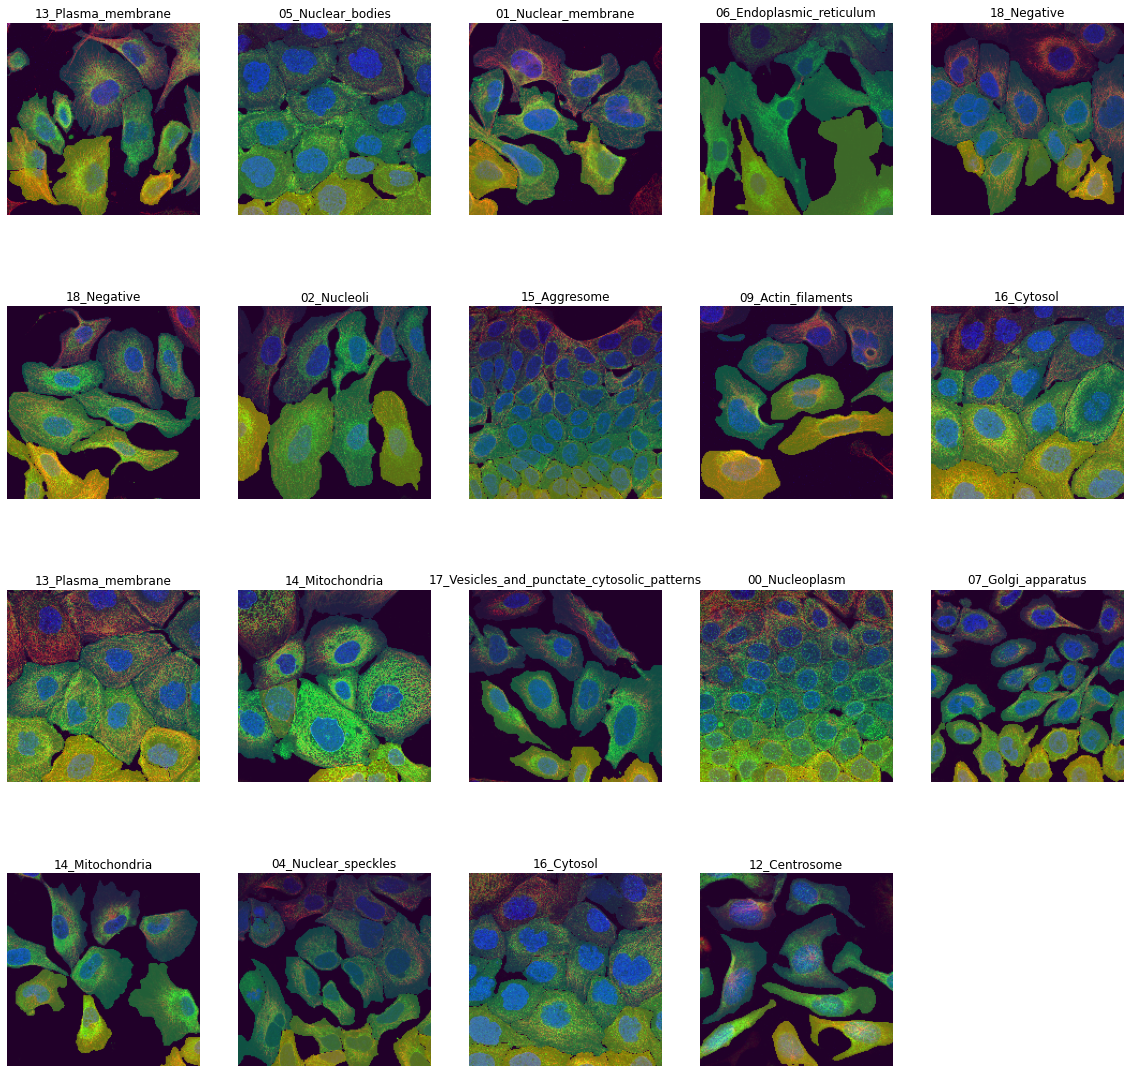

In [54]:
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
    for i in range(19):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")